Shape brute LLM : (6825, 58)
Après filtre Label_All valide : (6803, 59)
Après filtre confiance >= 80 : (1945, 59)
Shape Y (labels) : (1945, 6)
X_vec_train shape : (1945, 8000)
✅ Modèle XGB entraîné.
Shape RAW : (50000, 57)
X_vec_50k shape : (50000, 8000)
Exemple de lignes prédictes :
                                                 url  DIVERSITY  \
0  https://www.cadremploi.fr/emploi/detail_offre?...          1   
1  https://www.cadremploi.fr/emploi/detail_offre?...          0   
2  https://www.cadremploi.fr/emploi/detail_offre?...          1   
3  https://www.cadremploi.fr/emploi/detail_offre?...          1   
4  https://www.cadremploi.fr/emploi/detail_offre?...          0   

   REMUNERATION_BENEFITS  PROFESSIONAL_OPPORTUNITIES  CULTURE_VALUES  \
0                      0                           0               1   
1                      0                           1               1   
2                      0                           1               1   
3                      0

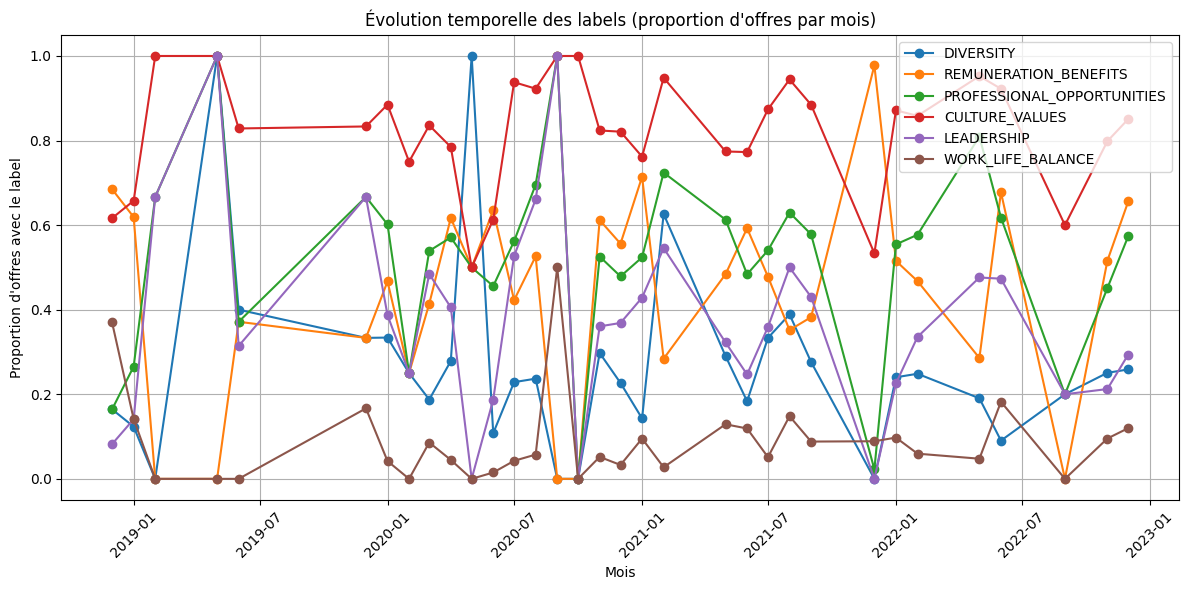

In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

# ============================================================
# 0. PATHS + CONSTANTES
# ============================================================
RAW_PATH    = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/sampled_data_full_fields_clean.jsonl"
LLM_PATH    = "/Users/noeamar/Documents/HEC/Jocas-HEC/Data/LLM_labels.jsonl"

CONF_THRESHOLD = 80  # on ne garde que les labels LLM avec confiance >= 80

VALID_LABELS = [
    "DIVERSITY",
    "REMUNERATION_BENEFITS",
    "PROFESSIONAL_OPPORTUNITIES",
    "CULTURE_VALUES",
    "LEADERSHIP",
    "WORK_LIFE_BALANCE",
]

TEXT_COLS = [
    "job_title",
    "description_job",
    "description_profil",
    "description_entreprise",
    "description_full",
]

# ============================================================
# 1. CHARGER LES DONNÉES LABELISÉES LLM
# ============================================================
records = []
with open(LLM_PATH, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        try:
            records.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df_llm = pd.DataFrame(records)
print("Shape brute LLM :", df_llm.shape)

# ============================================================
# 2. EXTRAIRE LES VECTEURS DE LABELS + CONFIANCE
# ============================================================

def extract_labels_and_confidence(d):
    """
    d = dictionnaire de la forme :
    {
      "DIVERSITY": 0/1,
      ...
      "WORK_LIFE_BALANCE": 0/1,
      "CONFIDENCE": 0-100
    }
    """
    if isinstance(d, dict) and all(k in d for k in VALID_LABELS) and "CONFIDENCE" in d:
        return {
            "vector": [d[k] for k in VALID_LABELS],
            "confidence": d["CONFIDENCE"],
        }
    return None

df_llm["label_info"] = df_llm["Label_All"].apply(extract_labels_and_confidence)
df_llm = df_llm[df_llm["label_info"].notnull()].reset_index(drop=True)
print("Après filtre Label_All valide :", df_llm.shape)

# Filtre confiance
df_train = df_llm[df_llm["label_info"].apply(lambda x: x["confidence"] >= CONF_THRESHOLD)].reset_index(drop=True)
print(f"Après filtre confiance >= {CONF_THRESHOLD} :", df_train.shape)

# ============================================================
# 3. CONSTRUIRE LE TEXTE D'ENTRÉE + MATRICE Y
# ============================================================
# texte concaténé (title + descriptions)
df_train["text"] = df_train[TEXT_COLS].fillna("").agg(" ".join, axis=1)

y = np.vstack(df_train["label_info"].apply(lambda x: x["vector"]).values).astype(int)
X_text_train = df_train["text"].values

print("Shape Y (labels) :", y.shape)

# ============================================================
# 4. TF-IDF + ENTRAÎNEMENT XGB MULTI-LABEL
# ============================================================
vectorizer = TfidfVectorizer(max_features=8000, ngram_range=(1, 2))
X_vec_train = vectorizer.fit_transform(X_text_train)
print("X_vec_train shape :", X_vec_train.shape)

# Modèle multi-sorties basé sur XGBoost
xgb_base = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    colsample_bytree=0.8,
    eval_metric="logloss",
    tree_method="hist",
)

model = MultiOutputClassifier(xgb_base)
model.fit(X_vec_train, y)

print("✅ Modèle XGB entraîné.")

# (Optionnel) petite évaluation rapide en CV ou train/test
# ... (tu peux remettre ta boucle de CV ici si tu veux)

# ============================================================
# 5. CHARGER LES 50K OFFRES ET LES LABELLISER
# ============================================================
df_raw = pd.read_json(RAW_PATH, lines=True)
print("Shape RAW :", df_raw.shape)

# Si tu veux vraiment 50k : 
df_50k = df_raw.head(50_000).copy()

# Construire le texte d'entrée de la même manière
df_50k["text"] = df_50k[TEXT_COLS].fillna("").agg(" ".join, axis=1)

X_vec_50k = vectorizer.transform(df_50k["text"].values)
print("X_vec_50k shape :", X_vec_50k.shape)

# Prédictions multi-label
y_pred_50k = model.predict(X_vec_50k)          # shape (N, 6)
df_pred = df_50k.copy()
for i, label in enumerate(VALID_LABELS):
    df_pred[label] = y_pred_50k[:, i]

print("Exemple de lignes prédictes :")
print(df_pred[["url"] + VALID_LABELS].head())

# ============================================================
# 6. ÉVOLUTION DES LABELS DANS LE TEMPS
# ============================================================
# On choisit une colonne de date : ici date_sitePublicationDay
# (adapte si besoin : date_firstSeenDay, etc.)
df_pred["date"] = pd.to_datetime(df_pred["date_sitePublicationDay"], errors="coerce")

# On garde les dates valides
df_pred = df_pred[df_pred["date"].notnull()].copy()

# Aggrégation par mois
df_pred["month"] = df_pred["date"].dt.to_period("M").dt.to_timestamp()

# Pour chaque mois : proportion d'offres où le label = 1
evolution = (
    df_pred.groupby("month")[VALID_LABELS]
           .mean()  # moyenne = part d'offres avec label=1
           .reset_index()
)

print("\nEvolution (head) :")
print(evolution.head())

# ============================================================
# 7. PLOT DES ÉVOLUTIONS
# ============================================================
plt.figure(figsize=(12, 6))
for label in VALID_LABELS:
    plt.plot(evolution["month"], evolution[label], marker="o", label=label)

plt.title("Évolution temporelle des labels (proportion d'offres par mois)")
plt.xlabel("Mois")
plt.ylabel("Proportion d'offres avec le label")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

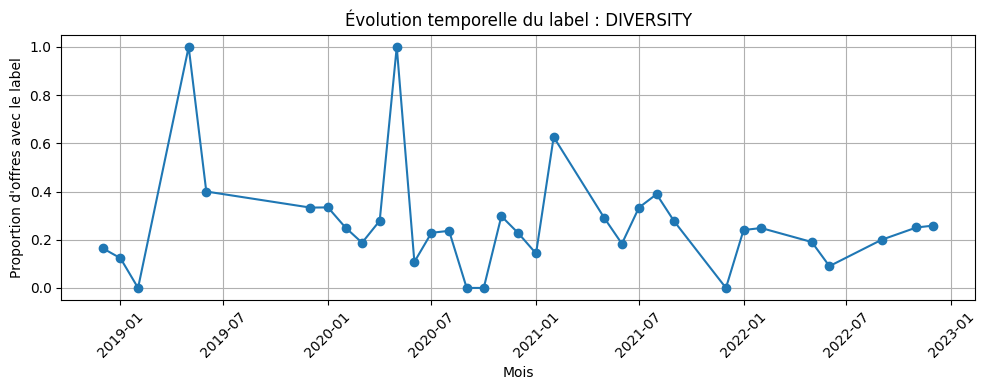

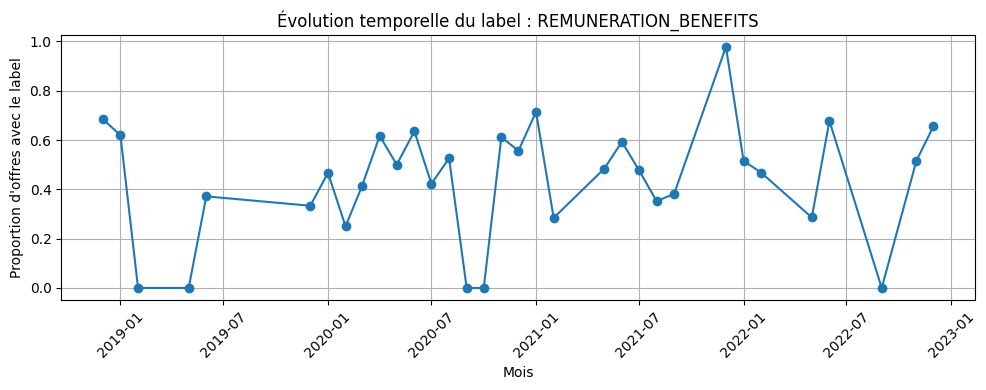

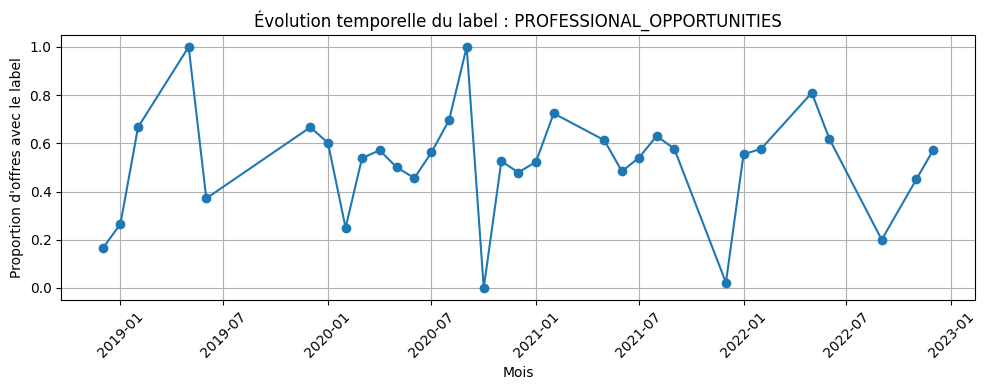

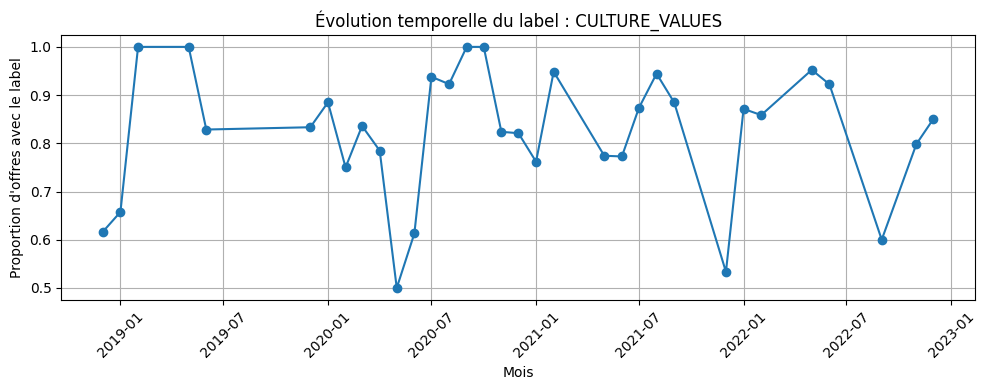

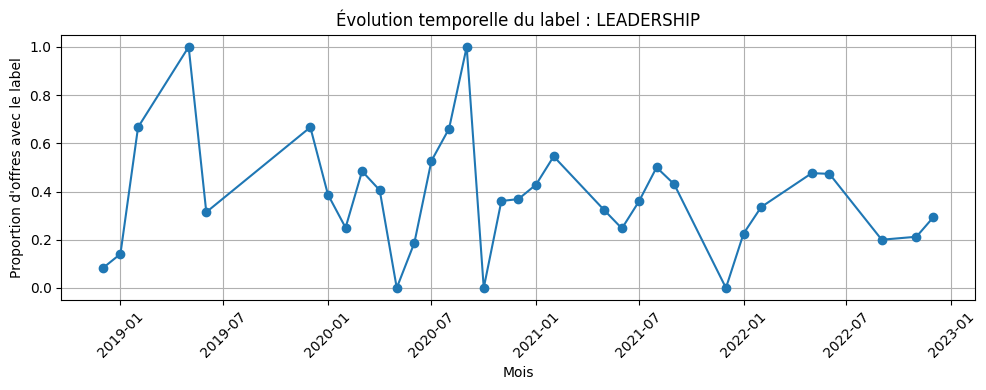

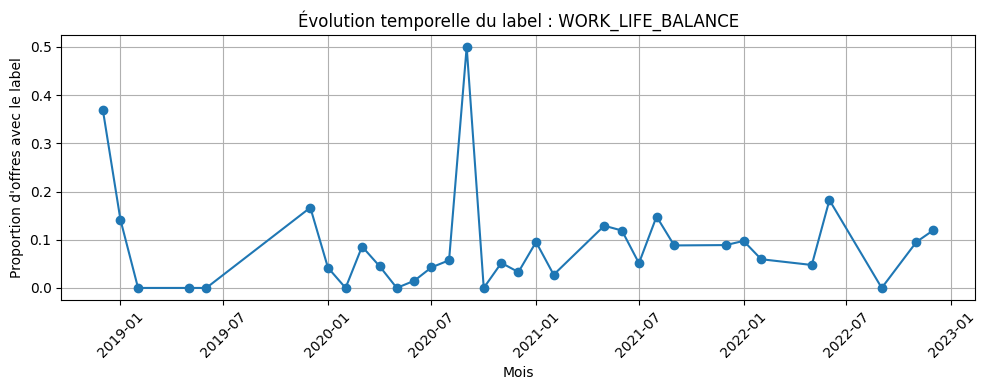

In [5]:
# ============================================================
# 7. PLOT DES ÉVOLUTIONS — UN GRAPHE PAR LABEL  📈
# ============================================================

for label in VALID_LABELS:
    plt.figure(figsize=(10, 4))
    plt.plot(evolution["month"], evolution[label], marker="o")
    plt.title(f"Évolution temporelle du label : {label}")
    plt.xlabel("Mois")
    plt.ylabel("Proportion d'offres avec le label")  # ⚠️ bien une proportion
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

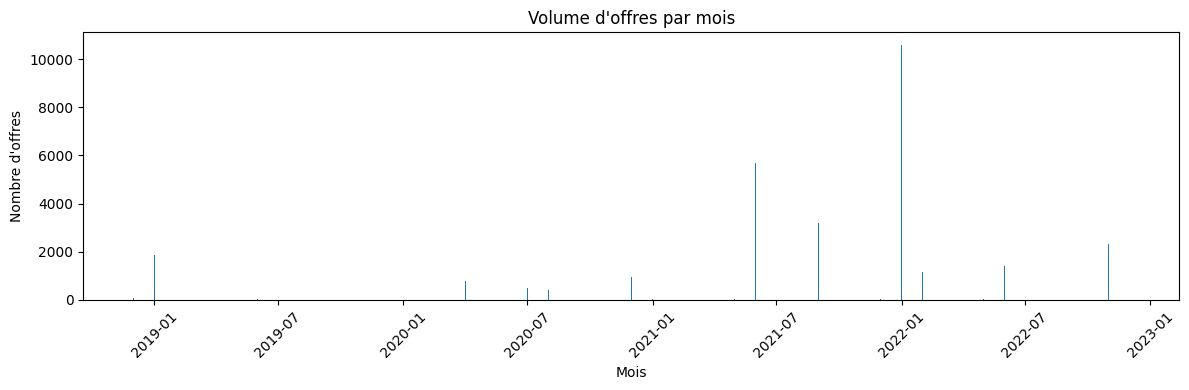

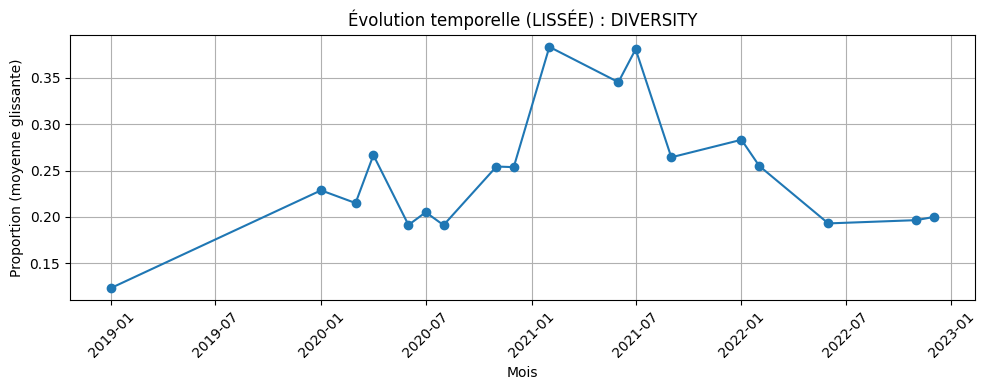

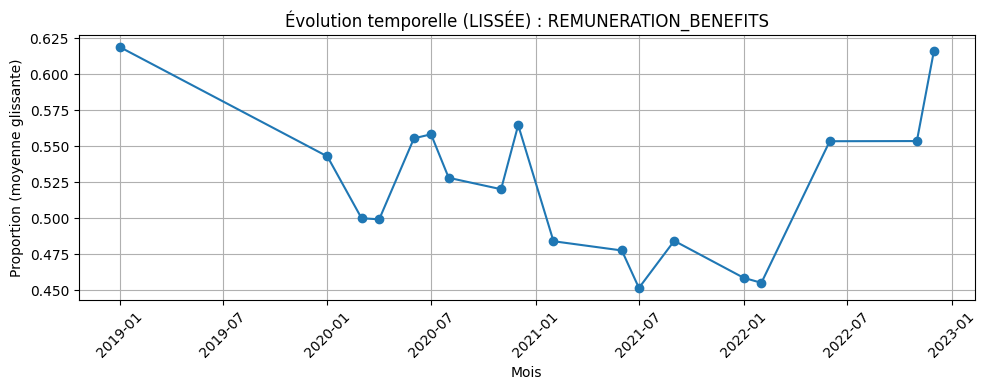

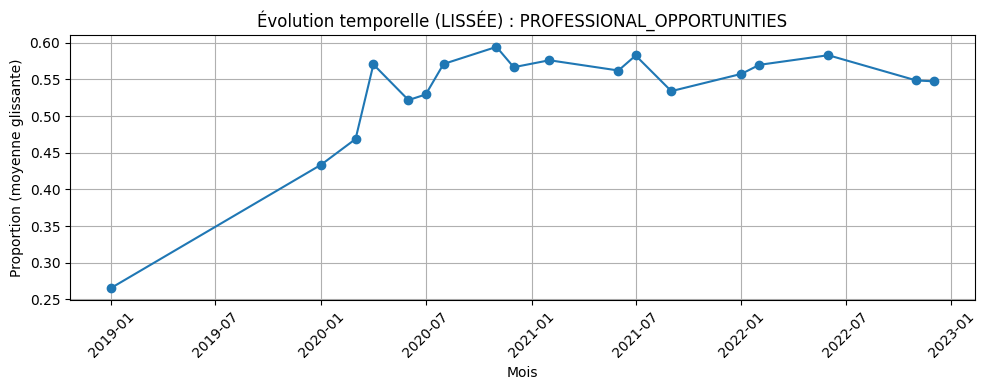

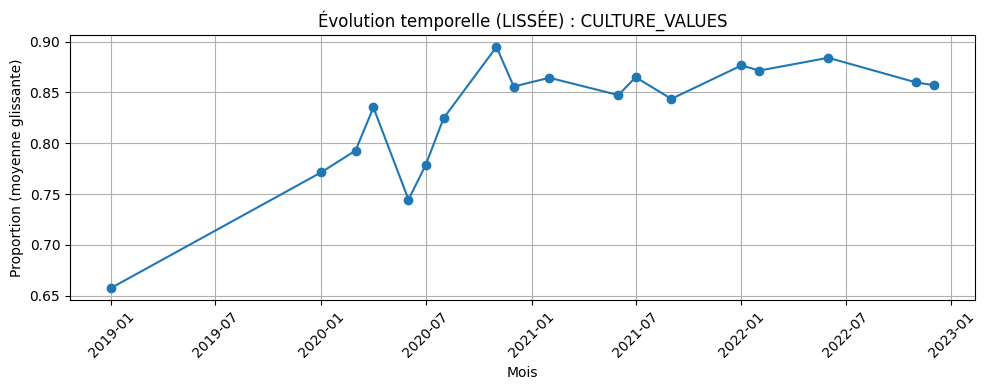

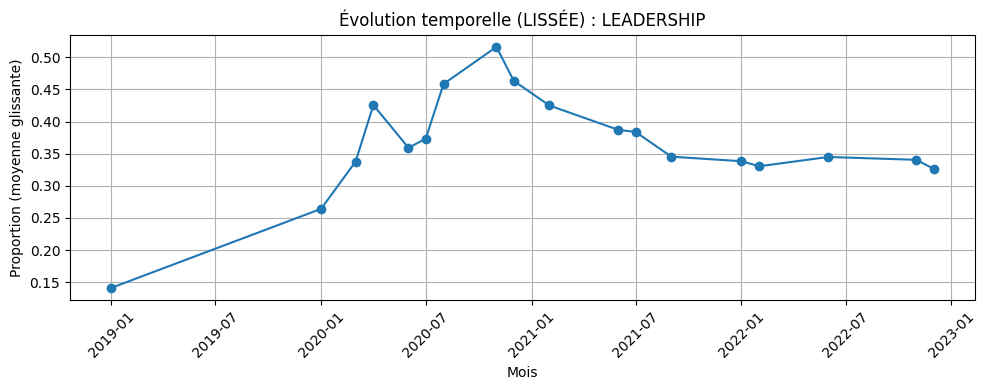

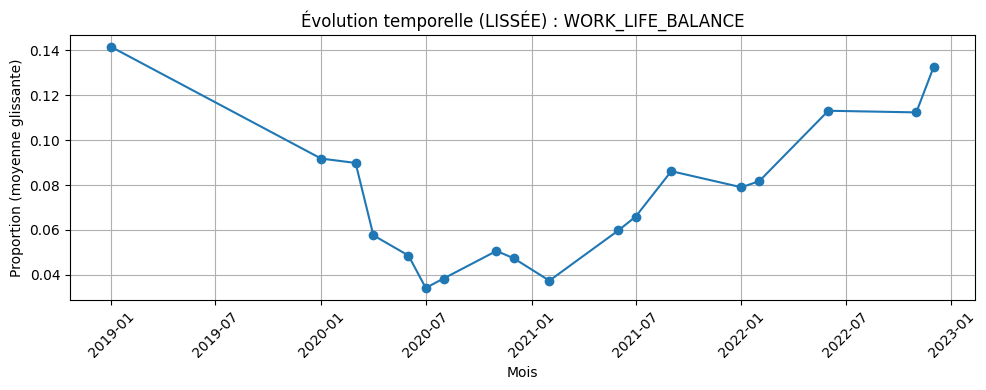

In [6]:
# 1) Voir le volume d'offres par mois
df_pred["month"] = df_pred["date"].dt.to_period("M").dt.to_timestamp()
count_per_month = df_pred.groupby("month")["url"].count()

plt.figure(figsize=(12,4))
plt.bar(count_per_month.index, count_per_month.values)
plt.title("Volume d'offres par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'offres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2) Filtrer les mois avec peu d'offres (ex. < 100)
valid_months = count_per_month[count_per_month >= 100].index
evolution_filtered = evolution[evolution["month"].isin(valid_months)].copy()

# 3) Lissage avec moyenne glissante (3 mois)
evolution_smooth = evolution_filtered.copy()
for label in VALID_LABELS:
    evolution_smooth[label] = evolution_filtered[label].rolling(window=3, min_periods=1).mean()

# 4) Plot lissé
for label in VALID_LABELS:
    plt.figure(figsize=(10,4))
    plt.plot(evolution_smooth["month"], evolution_smooth[label], marker="o")
    plt.title(f"Évolution temporelle (LISSÉE) : {label}")
    plt.xlabel("Mois")
    plt.ylabel("Proportion (moyenne glissante)")
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [7]:
import matplotlib.pyplot as plt

# -----------------------------------------
# 1) NOMBRE D'OFFRES PAR MOIS
# -----------------------------------------
offers_per_month = (
    df_pred.groupby("month")["url"]      # ou ID_JOCAS
           .count()
           .reset_index()
)

plt.figure(figsize=(8, 4))
plt.bar(offers_per_month["month"], offers_per_month["url"])
plt.title("Nombre d'offres par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'offres")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("offers_per_month.png")
plt.close()

# -----------------------------------------
# 2) EVOLUTION DE 2 LABELS CLÉS (LISSÉS)
# -----------------------------------------
labels_to_plot = ["CULTURE_VALUES", "WORK_LIFE_BALANCE"]

plt.figure(figsize=(8, 4))
for label in labels_to_plot:
    plt.plot(
        evolution["month"],
        evolution[label].rolling(window=3, min_periods=1).mean(),
        marker="o",
        label=label
    )

plt.title("Évolution temporelle de deux labels clés (moyenne glissante)")
plt.xlabel("Mois")
plt.ylabel("Proportion d'offres avec le label")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("label_evolution_combined.png")
plt.close()